In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca



In [2]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15   ZFYVE20  \
Patient_ID                                            ...                       
55_control    1.000000  0.363133  0.374212  0.611161  ...  0.468042  0.335792   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...  0.000000  0.159464   
72_control    0.648401  0.134017  0.200420  0.679453  ...  0.335173  0.241577   
120_control   0.579519  0.248934  0.759250  0.755407  ...  0.181256  0.297248   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...  0.319013  0.306320   
...                ...       ...       ...       ...  ...       ...       ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...  0.209212  0.301844   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...  0.408592  0.042243   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...  0.514164  0.364434   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...  0.428242  0.315197   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...  0.261123  0.099541   

              LOC100420253    LY6G5B   C5orf58  RSL24D1P1     MIEN1  \
Patient_ID                                                            
55_control             0.0  0.609518  0.535456        0.0  0.543158   
168_CD_plain           0.0  0.173529  0.018188        0.0  0.623796   
72_control             0.0  0.659563  0.000000        0.0  0.853118   
120_control            0.0  0.837676  0.480372        0.0  0.392582   
258_CD_plain           0.0  0.893448  0.485539        0.0  0.259900   
...                    ...       ...       ...        ...       ...   
15_CD_plain            0.0  0.643267  0.143476        0.0  0.262892   
182_CD_plain           0.0  0.765285  0.527984        0.0  0.413798   
164_CD_plain           0.0  0.930260  0.481733        0.0  0.273699   
53_CD_plain            0.0  0.877855  0.628071        0.0  0.183718   
97_CD_plain            0.0  0.156787  0.293838        0.0  0.561414   

              PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                     
55_control     0.622641           0.0     1.0  
168_CD_plain   0.301179           0.0     0.0  
72_control     0.431083           0.0     0.0  
120_control    0.390569           0.0     0.0  
258_CD_plain   0.431818           0.0     0.0  
...                 ...           ...     ...  
15_CD_plain    0.189790           0.0     0.0  
182_CD_plain   0.270021           0.0     0.0  
164_CD_plain   0.433093           0.0     0.0  
53_CD_plain    0.302030           0.0     0.0  
97_CD_plain    0.027077           0.0     0.0  

[182 rows x 219 columns]

In [3]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15  \
Patient_ID                                                 ...             
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...  0.339788   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...  0.354602   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...  0.320002   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...  0.445680   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...  0.419254   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.379431   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.181052   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.331961   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.416087   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.270050   

                    ZFYVE20  LOC100420253    LY6G5B   C5orf58  RSL24D1P1  \
Patient_ID                                                                 
253_CD_plain       0.326732           0.0  0.862246  0.074473        0.0   
105_CD_plain      -0.031527           0.0  0.717305  0.039214        0.0   
2_CD_plain         0.379134           0.0  0.604202  0.610072        0.0   
184_CD_plain       0.178908           0.0  0.702114  0.325357        0.0   
312_CD_plain       0.312215           0.0  0.821584  0.632007        0.0   
...                     ...           ...       ...       ...        ...   
107_CD_plain       0.233196           0.0  0.759342  0.567491        0.0   
279_CD_plain       0.342262           0.0  0.639644  0.540444        0.0   
179_CD_plain       0.275577           0.0  0.886616  0.658049        0.0   
70_CD_deep_ulcer   0.252402           0.0  0.931974  0.370181        0.0   
256_CD_deep_ulcer  0.268483           0.0  0.711803  0.243749        0.0   

                      MIEN1  PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                                    
253_CD_plain       0.498941   0.349920           0.0     0.0  
105_CD_plain       0.697073   0.268224           0.0     0.0  
2_CD_plain         0.324065   0.375123           0.0     0.0  
184_CD_plain       0.390919   0.185509           0.0     0.0  
312_CD_plain       0.183158   0.271359           0.0     0.0  
...                     ...        ...           ...     ...  
107_CD_plain       0.404604   0.190411           0.0     0.0  
279_CD_plain       0.397274   0.061934           0.0     0.0  
179_CD_plain       0.259391   0.471132           0.0     0.0  
70_CD_deep_ulcer   0.463922   0.413834           0.0     0.0  
256_CD_deep_ulcer  0.345240   0.380147           0.0     0.0  

[78 rows x 219 columns]

In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
compound_model = keras.models.load_model('cd_clf')

In [7]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 438)               96360     
                                                                 
 batch_normalization (BatchN  (None, 438)              1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 438)               0         
                                                                 
 dense_1 (Dense)             (None, 219)               96141     
                                                                 
 batch_normalization_1 (Batc  (None, 219)              876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 219)               0

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

AADAC     APOA1
Patient_ID                      
253_CD_plain  0.869185  0.841880
105_CD_plain  0.853562  0.933532

In [9]:
import objects

In [10]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="identity", feature_dependence=True, specific_indices=[41])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [21]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [22]:
# shap_values

## Dependent - 41

In [23]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [11]:

with open("shap_values_builtin_gmm_41_iden_mult", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [12]:
# shap_values[0][0].shape

In [13]:
shap_values = shap_values[0]

In [14]:
# shap_values[0] *= 100000

In [15]:
shap_values

[array([[ -3.87933389, -10.8332114 ,   0.59268833,   0.        ,
          -0.57537928,   0.        ,   0.        ,  -8.90409892,
           1.17557239,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   7.3491467 ,  11.6880511 ,
           0.        ,   0.        ,  -8.85477416,   0.        ,
           0.        ,   0.        ,   5.19198355,   0.        ,
          -3.55160405,   0.        ,   0.        ,   0.        ,
           0.        ,   7.57550472,  -7.74326082,  -3.2352587 ,
           0.        ,   2.58330334,  -3.24138208,   0.        ,
           0.        ,  10.43685761,  -0.66903204,   2.36310037,
           0.        ,   1.54793335,   0.        ,   0.        ,
          -2.14666539,   0.        ,   0.        ,   0.        ,
           0.        , -16.50729048,   0.        ,   0.        ,
         -23.44921222,   0.        ,  -7.24746524,   0.        ,
          -0.45241093,   0.        ,   0.        ,  -7.40068779,
          -2.7328658 ,   

In [16]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 219)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [17]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15  \
Patient_ID                                                 ...             
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...  0.327476   

                    ZFYVE20  LOC100420253    LY6G5B   C5orf58  RSL24D1P1  \
Patient_ID                                                                 
260_CD_deep_ulcer  0.256429           0.0  0.787863  0.559487        0.0   

                      MIEN1  PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                                    
260_CD_deep_ulcer  0.363882   0.283622           0.0     0.0  

[1 rows x 219 columns]

In [18]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 88ms/step
Prediction probabilities for patient: [0.02258483 0.4199654  0.5574499 ]
Predicted class:


#### Control

In [19]:
import shap

In [20]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="identity")

####  CD no ulcer

In [21]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="identity")

####  CD deep ulcer

In [22]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="identity")

In [23]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

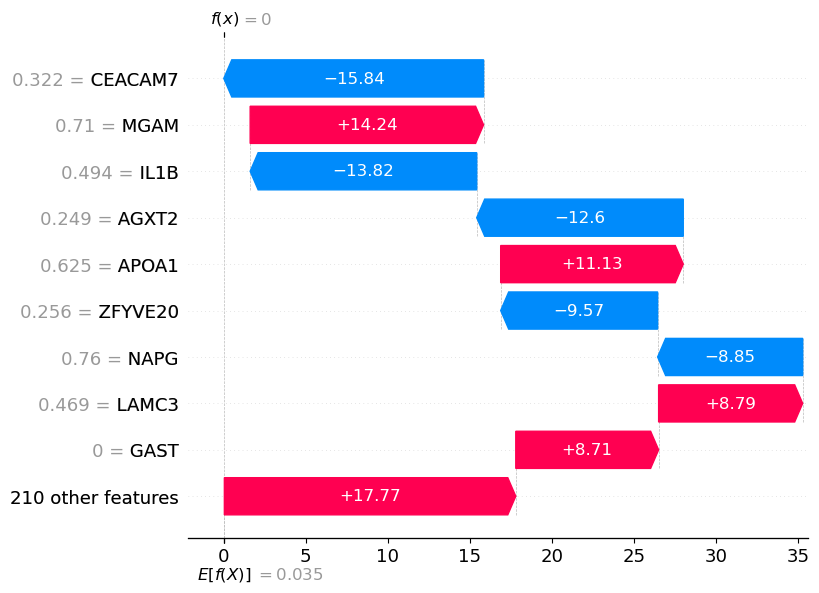

In [24]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 18

In [40]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [56]:

with open("shap_values_builtin_gmm_18_iden_mult", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [57]:
# shap_values[0][0].shape

In [58]:
shap_values = shap_values[0]

In [59]:
# shap_values[0] *= 100000

In [60]:
shap_values

[array([[ -3.53036051,   0.        ,   0.05031468,   0.        ,
           1.90871763,   9.48518665,   0.        , -11.30361839,
           0.25438093,   0.        ,  -1.58592583,   0.        ,
           1.42438876,   0.        ,   3.36243913,   3.33023181,
           3.32159262,   3.70620826,   8.11031119,   0.        ,
           0.        ,   0.        ,   0.        ,  -5.67188837,
           0.        ,   0.        ,  -2.87959988,   5.77115833,
           0.        ,  -7.99031865,  -5.34775733,   0.        ,
           0.        ,  -2.05957912,  -2.34147049,   0.        ,
           0.        ,  10.18512457,   0.        ,   0.61842702,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,  -4.68703759,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
          -0.38721709,   0.        ,  -0.16242344,   1.83178913,
           1.16396842,   4.88947787,   0.        ,   9.50121149,
           0.        ,   

In [61]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 219)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [62]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15  \
Patient_ID                                                ...             
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...  0.403676   

                   ZFYVE20  LOC100420253    LY6G5B   C5orf58  RSL24D1P1  \
Patient_ID                                                                
46_CD_deep_ulcer  0.276644           0.0  0.548505  0.391732        0.0   

                     MIEN1  PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                                   
46_CD_deep_ulcer  0.243567   0.144529           0.0     0.0  

[1 rows x 219 columns]

In [63]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 13ms/step
Prediction probabilities for patient: [0.00382106 0.75586474 0.24031425]
Predicted class:


#### Control

In [64]:
import shap

In [65]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="identity")

####  CD no ulcer

In [66]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="identity")

####  CD deep ulcer

In [67]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="identity")

In [69]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

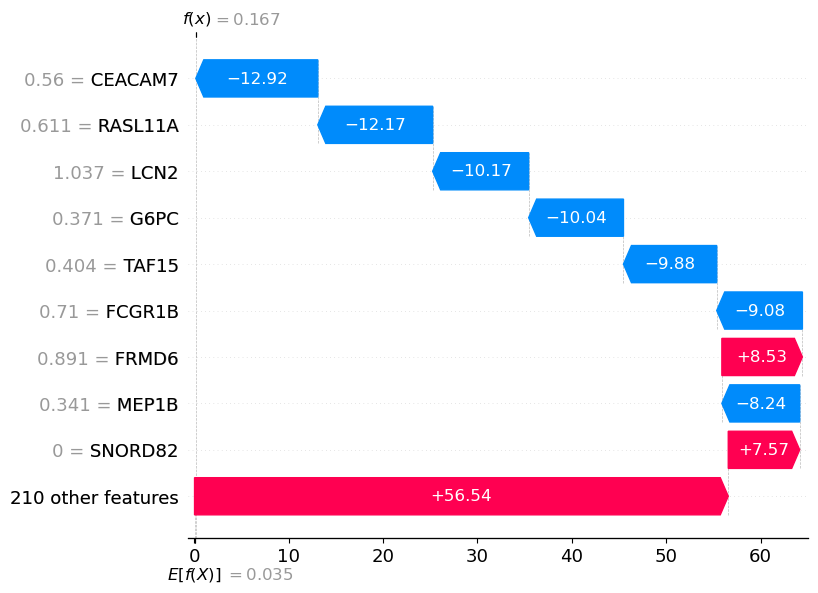

In [70]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Independent - 18

In [26]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="identity", feature_dependence=False, specific_indices=[18])

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [27]:


with open("shap_values_gmm_ind_18", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [28]:
shap_values = shap_values[0]

In [29]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 219)


In [30]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15  \
Patient_ID                                                ...             
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...  0.403676   

                   ZFYVE20  LOC100420253    LY6G5B   C5orf58  RSL24D1P1  \
Patient_ID                                                                
46_CD_deep_ulcer  0.276644           0.0  0.548505  0.391732        0.0   

                     MIEN1  PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                                   
46_CD_deep_ulcer  0.243567   0.144529           0.0     0.0  

[1 rows x 219 columns]

In [31]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:")

Prediction probabilities for patient: [1.45517256e-62 1.09419538e-05 1.67053047e-01]
Predicted class:


#### Control

In [32]:
import shap

In [33]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="identity")

####  CD no ulcer

In [34]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="identity")

####  CD deep ulcer

In [36]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [38]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

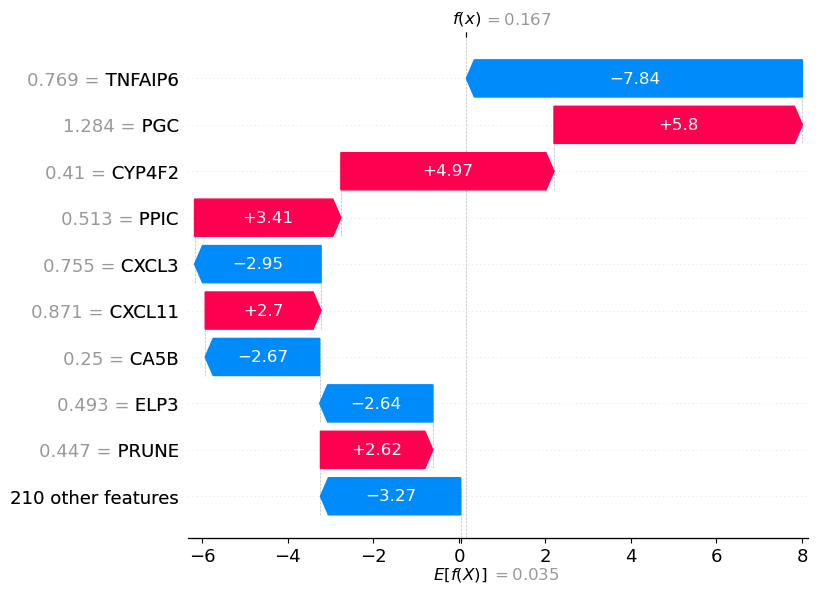

In [39]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Independent - 77

In [42]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="identity", feature_dependence=False, specific_indices=[18])

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [43]:


with open("shap_values_builtin_gmm_77_iden_mult_ind", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [44]:
shap_values = shap_values[0]

In [45]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 219)


In [46]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...    TAF15   ZFYVE20  \
Patient_ID                                           ...                      
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...  0.27005  0.268483   

                   LOC100420253    LY6G5B   C5orf58  RSL24D1P1    MIEN1  \
Patient_ID                                                                
256_CD_deep_ulcer           0.0  0.711803  0.243749        0.0  0.34524   

                   PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                          
256_CD_deep_ulcer   0.380147           0.0     0.0  

[1 rows x 219 columns]

In [47]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:")

Prediction probabilities for patient: [9.22177211e-17 8.78939155e+01 2.02737842e-12]
Predicted class:


#### Control

In [48]:
import shap

In [49]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="identity")

####  CD no ulcer

In [50]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="identity")

####  CD deep ulcer

In [51]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [54]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

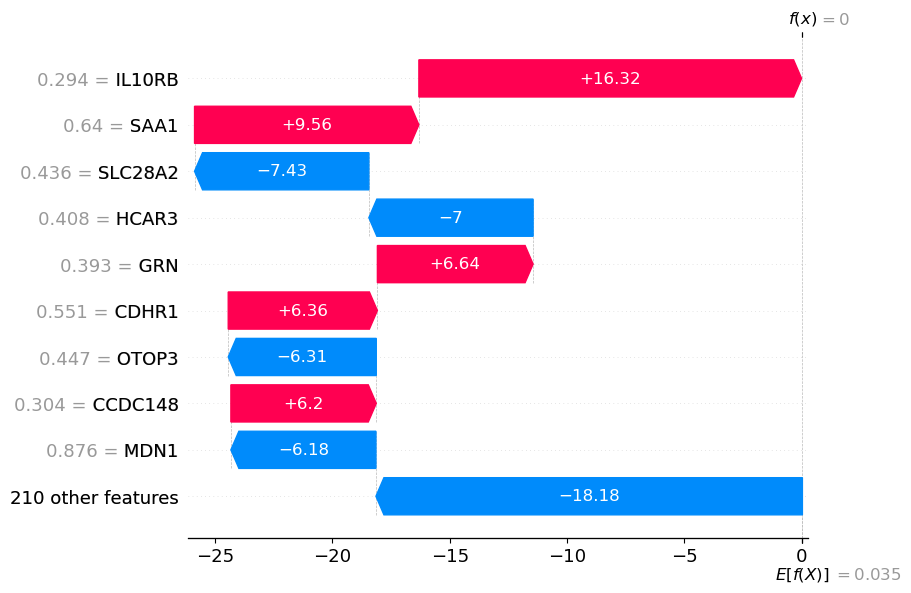

In [55]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))